# Analysis of varience

## Table of Contents
- [Importing packages](#importing)
- [Reading and preprocessing](#reading)
- [Using Tree to predict gender](#tree)
- [Visuals](#visuals)
    - [Distributions](#distrib)
    - [Scatterplots](#scatter)
- [One way analysis of varience](#one_way)
    - [ANOVA assumptions](#assumptions)
        - [Q-Q plot, Shapiro-Wilk test](#q-q)
        - [Homogenity of variances](#homo)
- [Calculations](#calc)
    - [Drawing F-distribution](#f-distrib)
    - [Tukey HSD test](#tukey)
    
- [Conclusion](#conc)

<a id='importing'></a>
### Importing packages

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn import tree
from scipy.stats import f
from statsmodels.stats.multicomp import pairwise_tukeyhsd
np.random.seed(42)
sns.set()
sns.set_style("dark")
plt.style.use(['seaborn-muted'])
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina' 

<a id='reading'></a>
### Reading and preprocessing

In [2]:
df = pd.read_csv('diet.csv')

In [3]:
df.head()

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3


In [4]:
df.shape

(78, 7)

In [5]:
df.rename({'Person':'person_id', 'pre.weight':'weight_before', 'weight6weeks':'weight_after'}, inplace=True, axis=1)

In [6]:
df.columns = [x.lower() for x in df.columns]

In [7]:
df.sort_values('person_id', inplace=True)

In [8]:
df.set_index('person_id', inplace=True)

In [9]:
df.isnull().sum()

gender           0
age              0
height           0
weight_before    0
diet             0
weight_after     0
dtype: int64

In [10]:
df['weight_lost'] = df['weight_before'] - df['weight_after']

In [11]:
df[df['weight_lost'] < 0]

,gender,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,,
15,1,39,168,71,1,71.6,-0.6
27,0,44,174,58,2,60.1,-2.1
40,0,29,169,77,2,77.5,-0.5
50,1,39,180,80,2,81.4,-1.4


In [12]:
df.head()

,gender,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,,
1,0,22,159,58,1,54.2,3.8
2,0,46,192,60,1,54.0,6.0
3,0,55,170,64,1,63.3,0.7
4,0,33,171,64,1,61.1,2.9
5,0,50,170,65,1,62.2,2.8


In [13]:
# Check for consistency in the dataset
for column in df.columns:
    print(f'Column {column} has {df[column].nunique()} unique values')

Column gender has 3 unique values
Column age has 35 unique values
Column height has 37 unique values
Column weight_before has 30 unique values
Column diet has 3 unique values
Column weight_after has 69 unique values
Column weight_lost has 54 unique values


In [14]:
df['gender'].unique()



array(['0', '1', ' '], dtype=object)

In [15]:
df[df['gender'] == ' ']

,gender,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,,
25,,41,171,60,2,60.0,0.0
26,,32,174,103,2,103.0,0.0


So, we have good and bad news:
 - Bad news:
     two empty strings in our analysis could have an impact on our results and in sake of an experiment
     we can't use this dataset.
 - Good news:
     We have simple yet very effective technique for predicting different values.
     Let's use Decision tree to predict gender

<a id='tree'></a>
### Using Tree to predict gender

In [16]:
# Get rid of empty strings
exp_df = df[~(df['gender'] == " ")]

In [17]:
cols = exp_df.columns.tolist()
cols.remove('gender')
X = exp_df[cols]
y = exp_df['gender']
X_test = df[df['gender'] == ' ']
X_test.drop(['gender'], inplace=True, axis=1)

In [18]:
X_test

,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,
25,41,171,60,2,60.0,0.0
26,32,174,103,2,103.0,0.0


In [19]:
X.head()

,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,
1,22,159,58,1,54.2,3.8
2,46,192,60,1,54.0,6.0
3,55,170,64,1,63.3,0.7
4,33,171,64,1,61.1,2.9
5,50,170,65,1,62.2,2.8


In [20]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X.values, y.values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

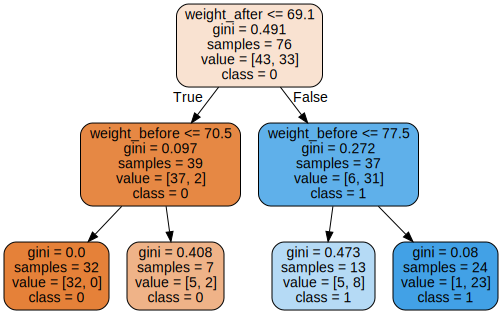

In [21]:
tree_graph = tree.export_graphviz(clf, out_file=None, max_depth=10,
    impurity=True, feature_names=cols, class_names=['0', '1'],
    rounded=True, filled=True)
graphviz.Source(tree_graph) 

After predicting gender, we can safely conduct our analysis;

In [22]:
df.loc[25:26,'gender'] = clf.predict(X_test.values)

In [23]:
df.loc[25:26]

,gender,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,,
25,0,41,171,60,2,60.0,0.0
26,1,32,174,103,2,103.0,0.0


After all, it is better to replace 0 and 1 with F and M correspondingly

In [24]:
df['gender'].replace({'0':'F','1':'M'}, inplace=True)

In [25]:
df.head()

,gender,age,height,weight_before,diet,weight_after,weight_lost
person_id,,,,,,,
1,F,22,159,58,1,54.2,3.8
2,F,46,192,60,1,54.0,6.0
3,F,55,170,64,1,63.3,0.7
4,F,33,171,64,1,61.1,2.9
5,F,50,170,65,1,62.2,2.8


<a id='visuals'></a>
### Some visual explorations

In [26]:
def plot_distrib(parameter) -> None:
    """
    Creates distribution plot
    ------------------------    
    Parameters:
    parameter : str
    """
    fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(8,10))
    F = df[df['gender'] == 'F']
    M = df[df['gender'] == 'M']
    sns.distplot(F[parameter], ax=ax1)
    ax1.set(xlabel=parameter, ylabel='Density', title=f"Distribution of women's {parameter}")
    sns.distplot(M[parameter], ax=ax2)
    ax2.set(xlabel=parameter, ylabel='Density', title=f"Distribution of men's {parameter}")
    sns.distplot(df[parameter], ax=ax3)
    ax3.set(xlabel=parameter, ylabel='Density', title=f'General {parameter} distribution')
    plt.tight_layout()

<a id='distrib'></a>
#### Distributions

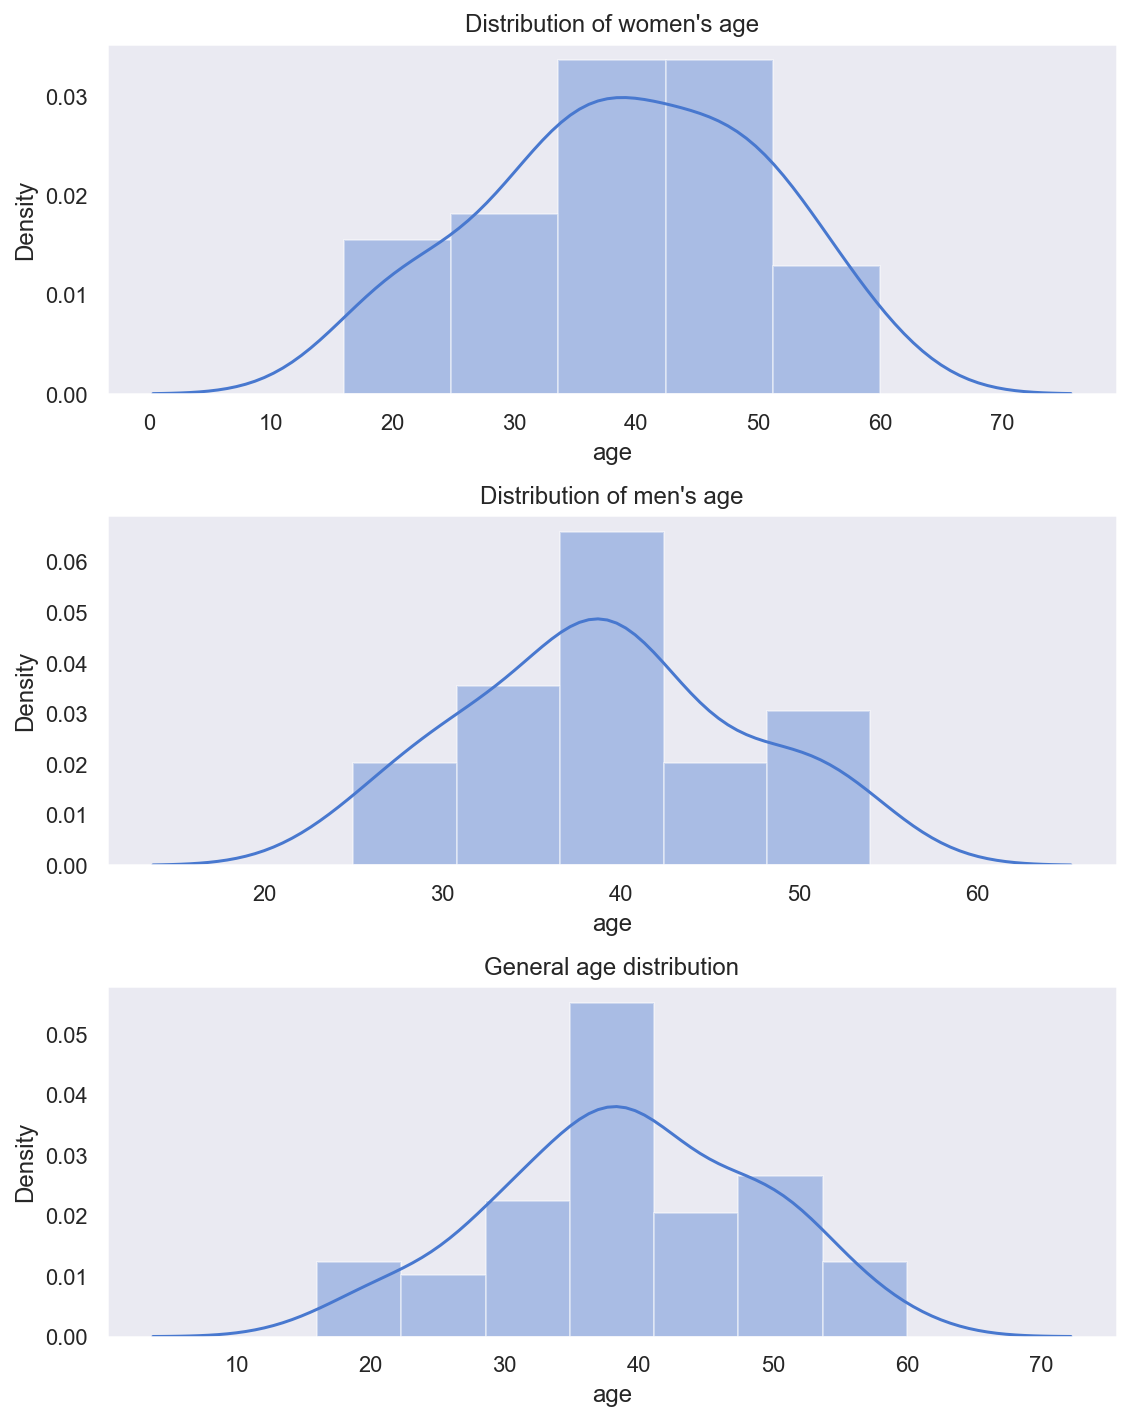

In [27]:
plot_distrib('age')

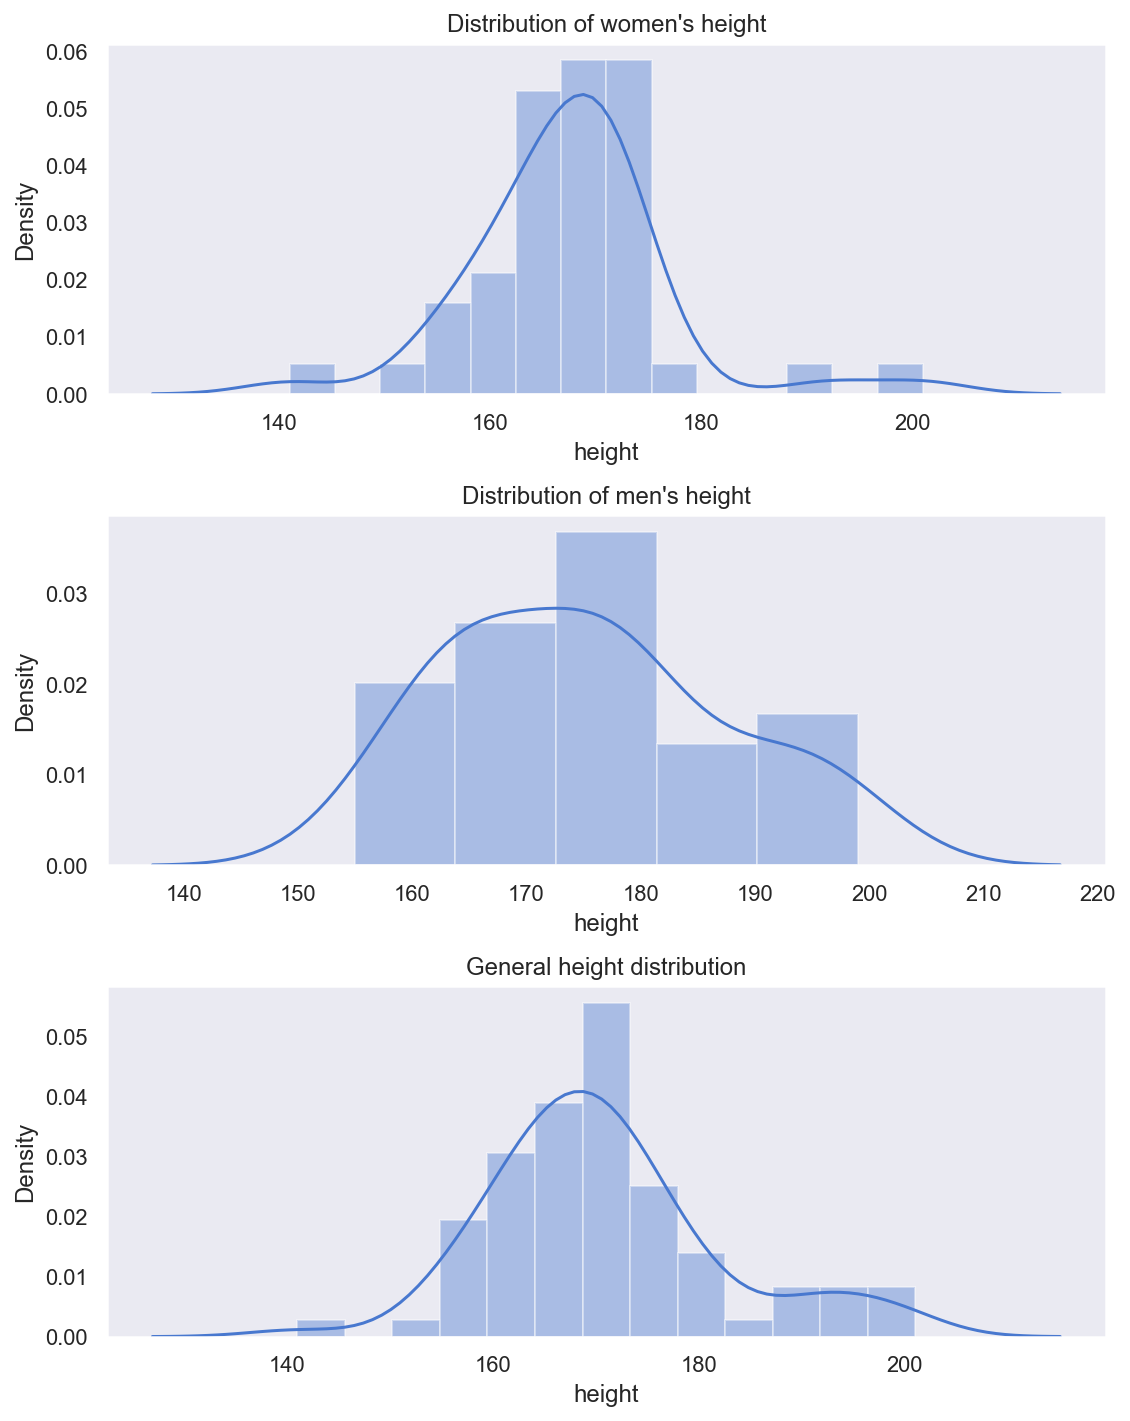

In [28]:
plot_distrib('height')

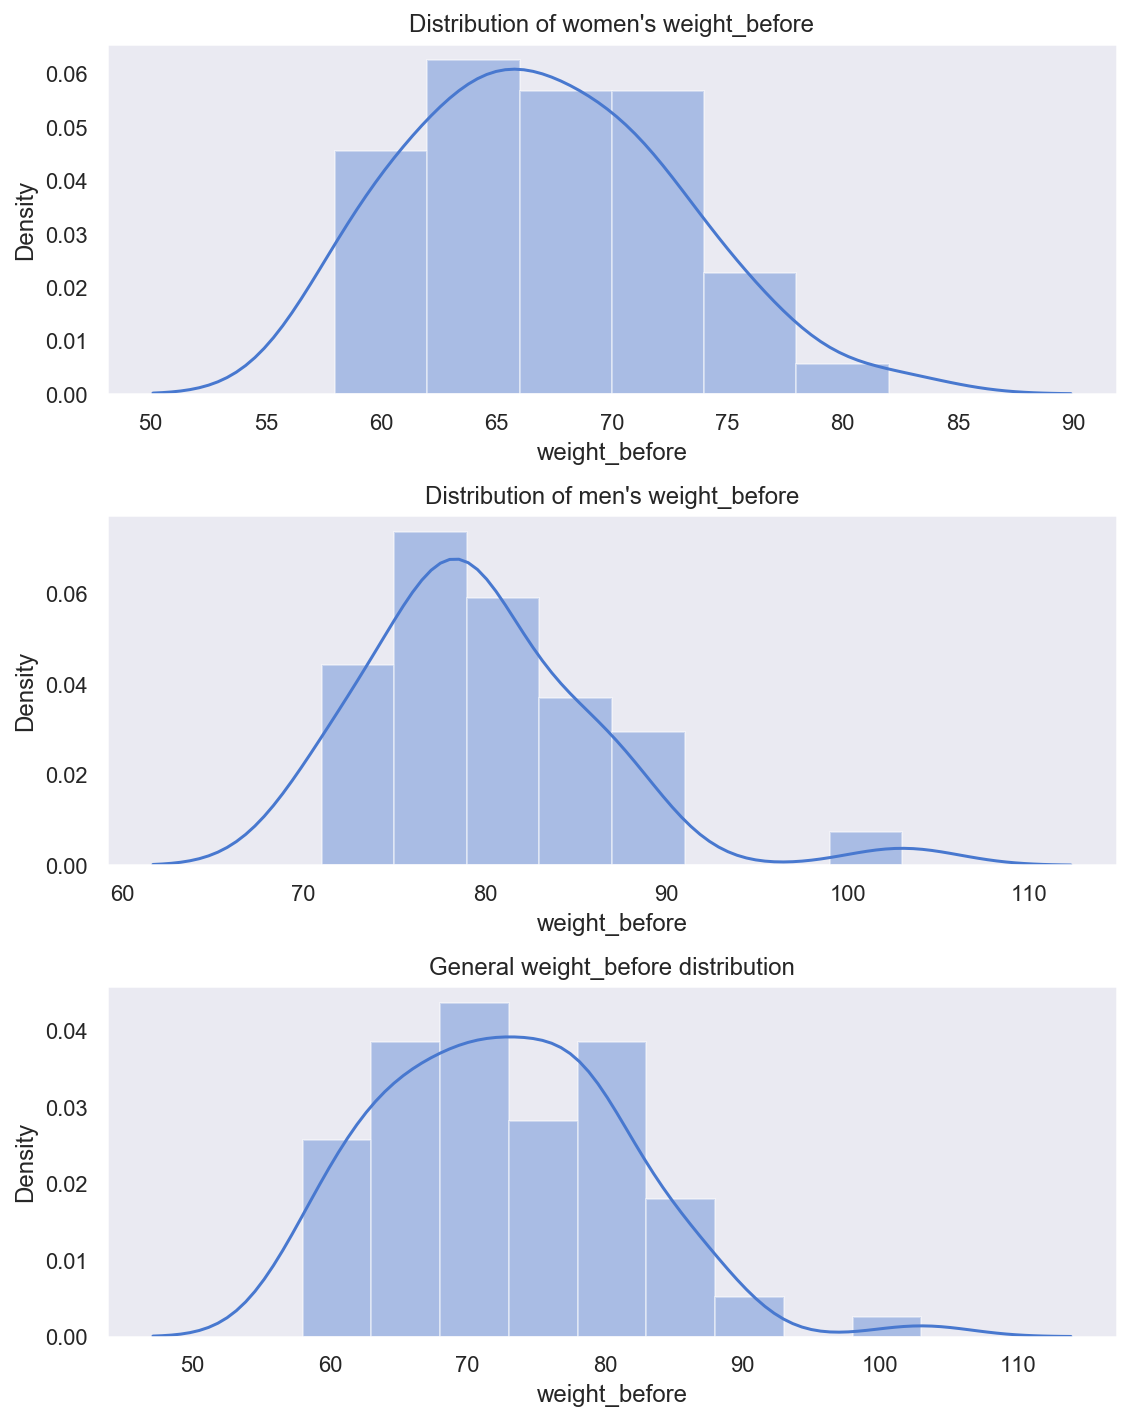

In [29]:
plot_distrib('weight_before')

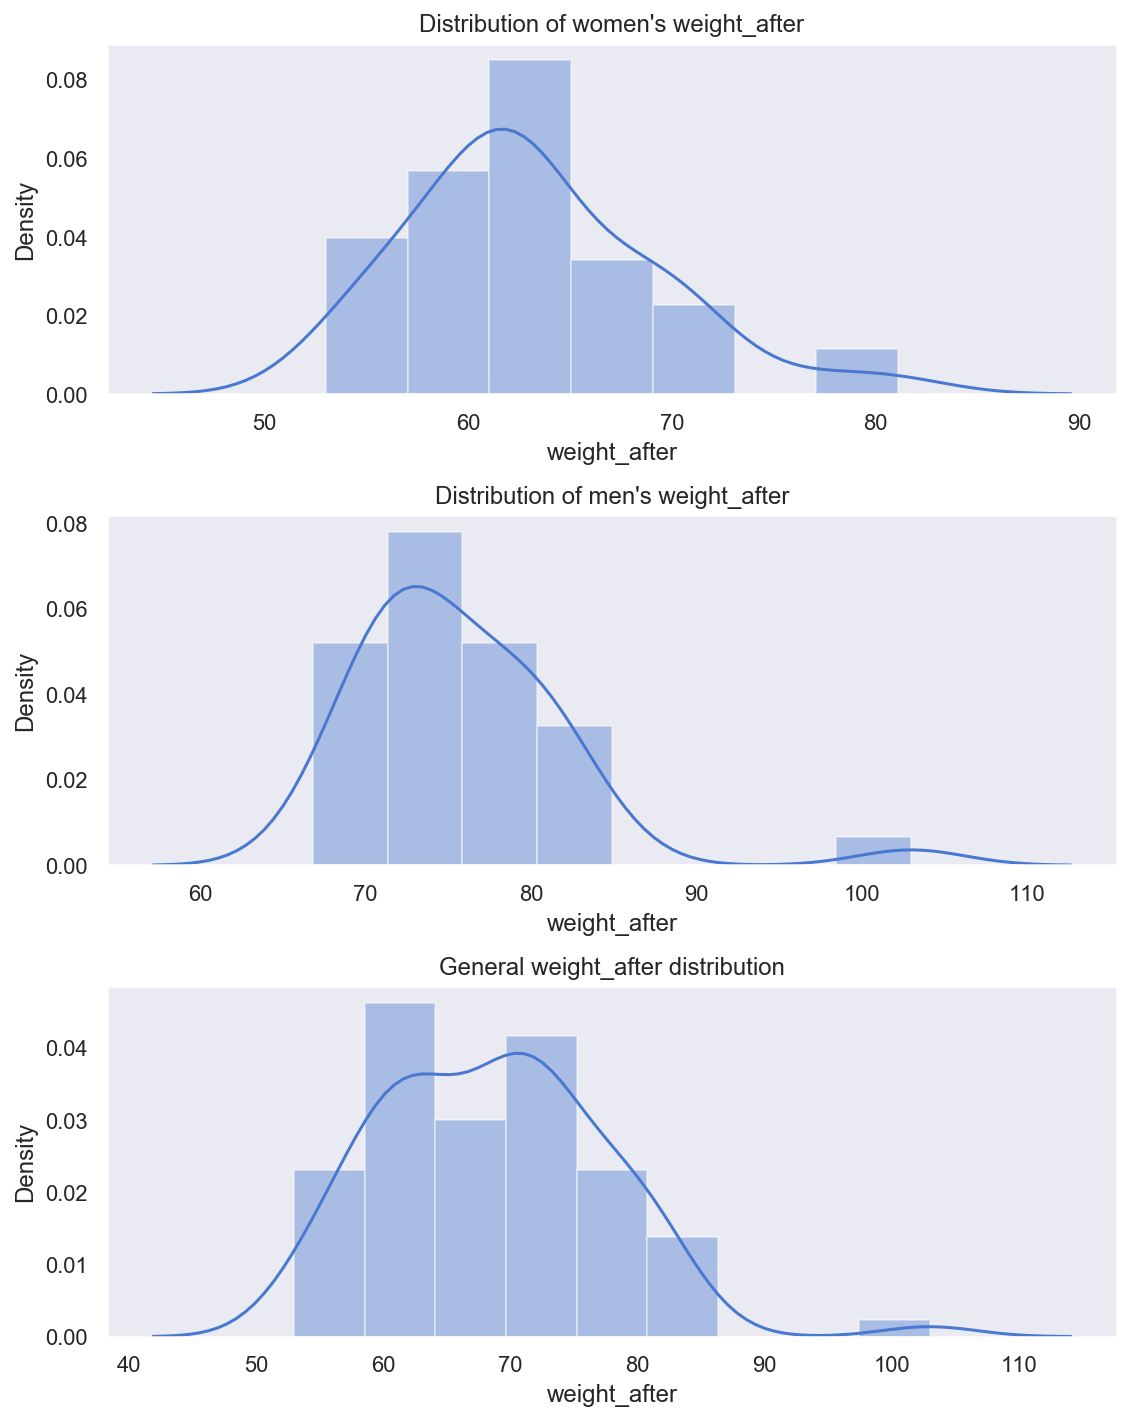

In [30]:
plot_distrib('weight_after')

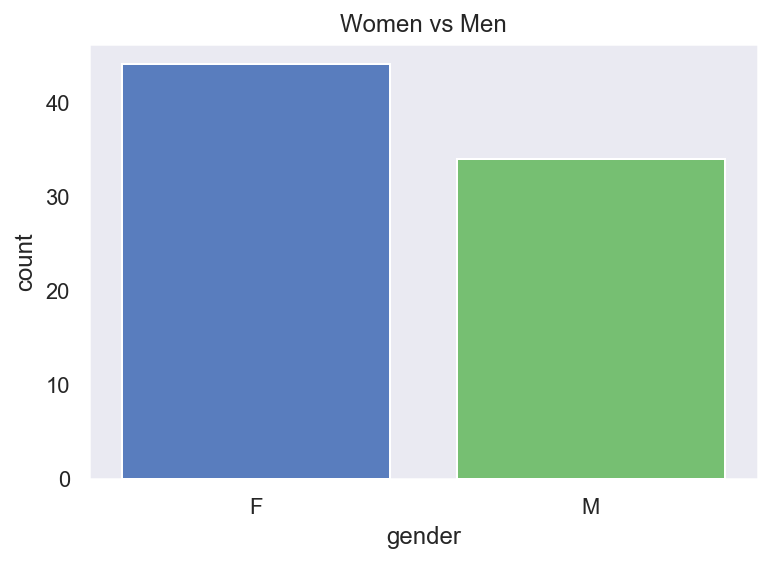

In [31]:
sns.countplot(df['gender'])
plt.title('Women vs Men');

<a id='scatter'></a>
### Scatterplots

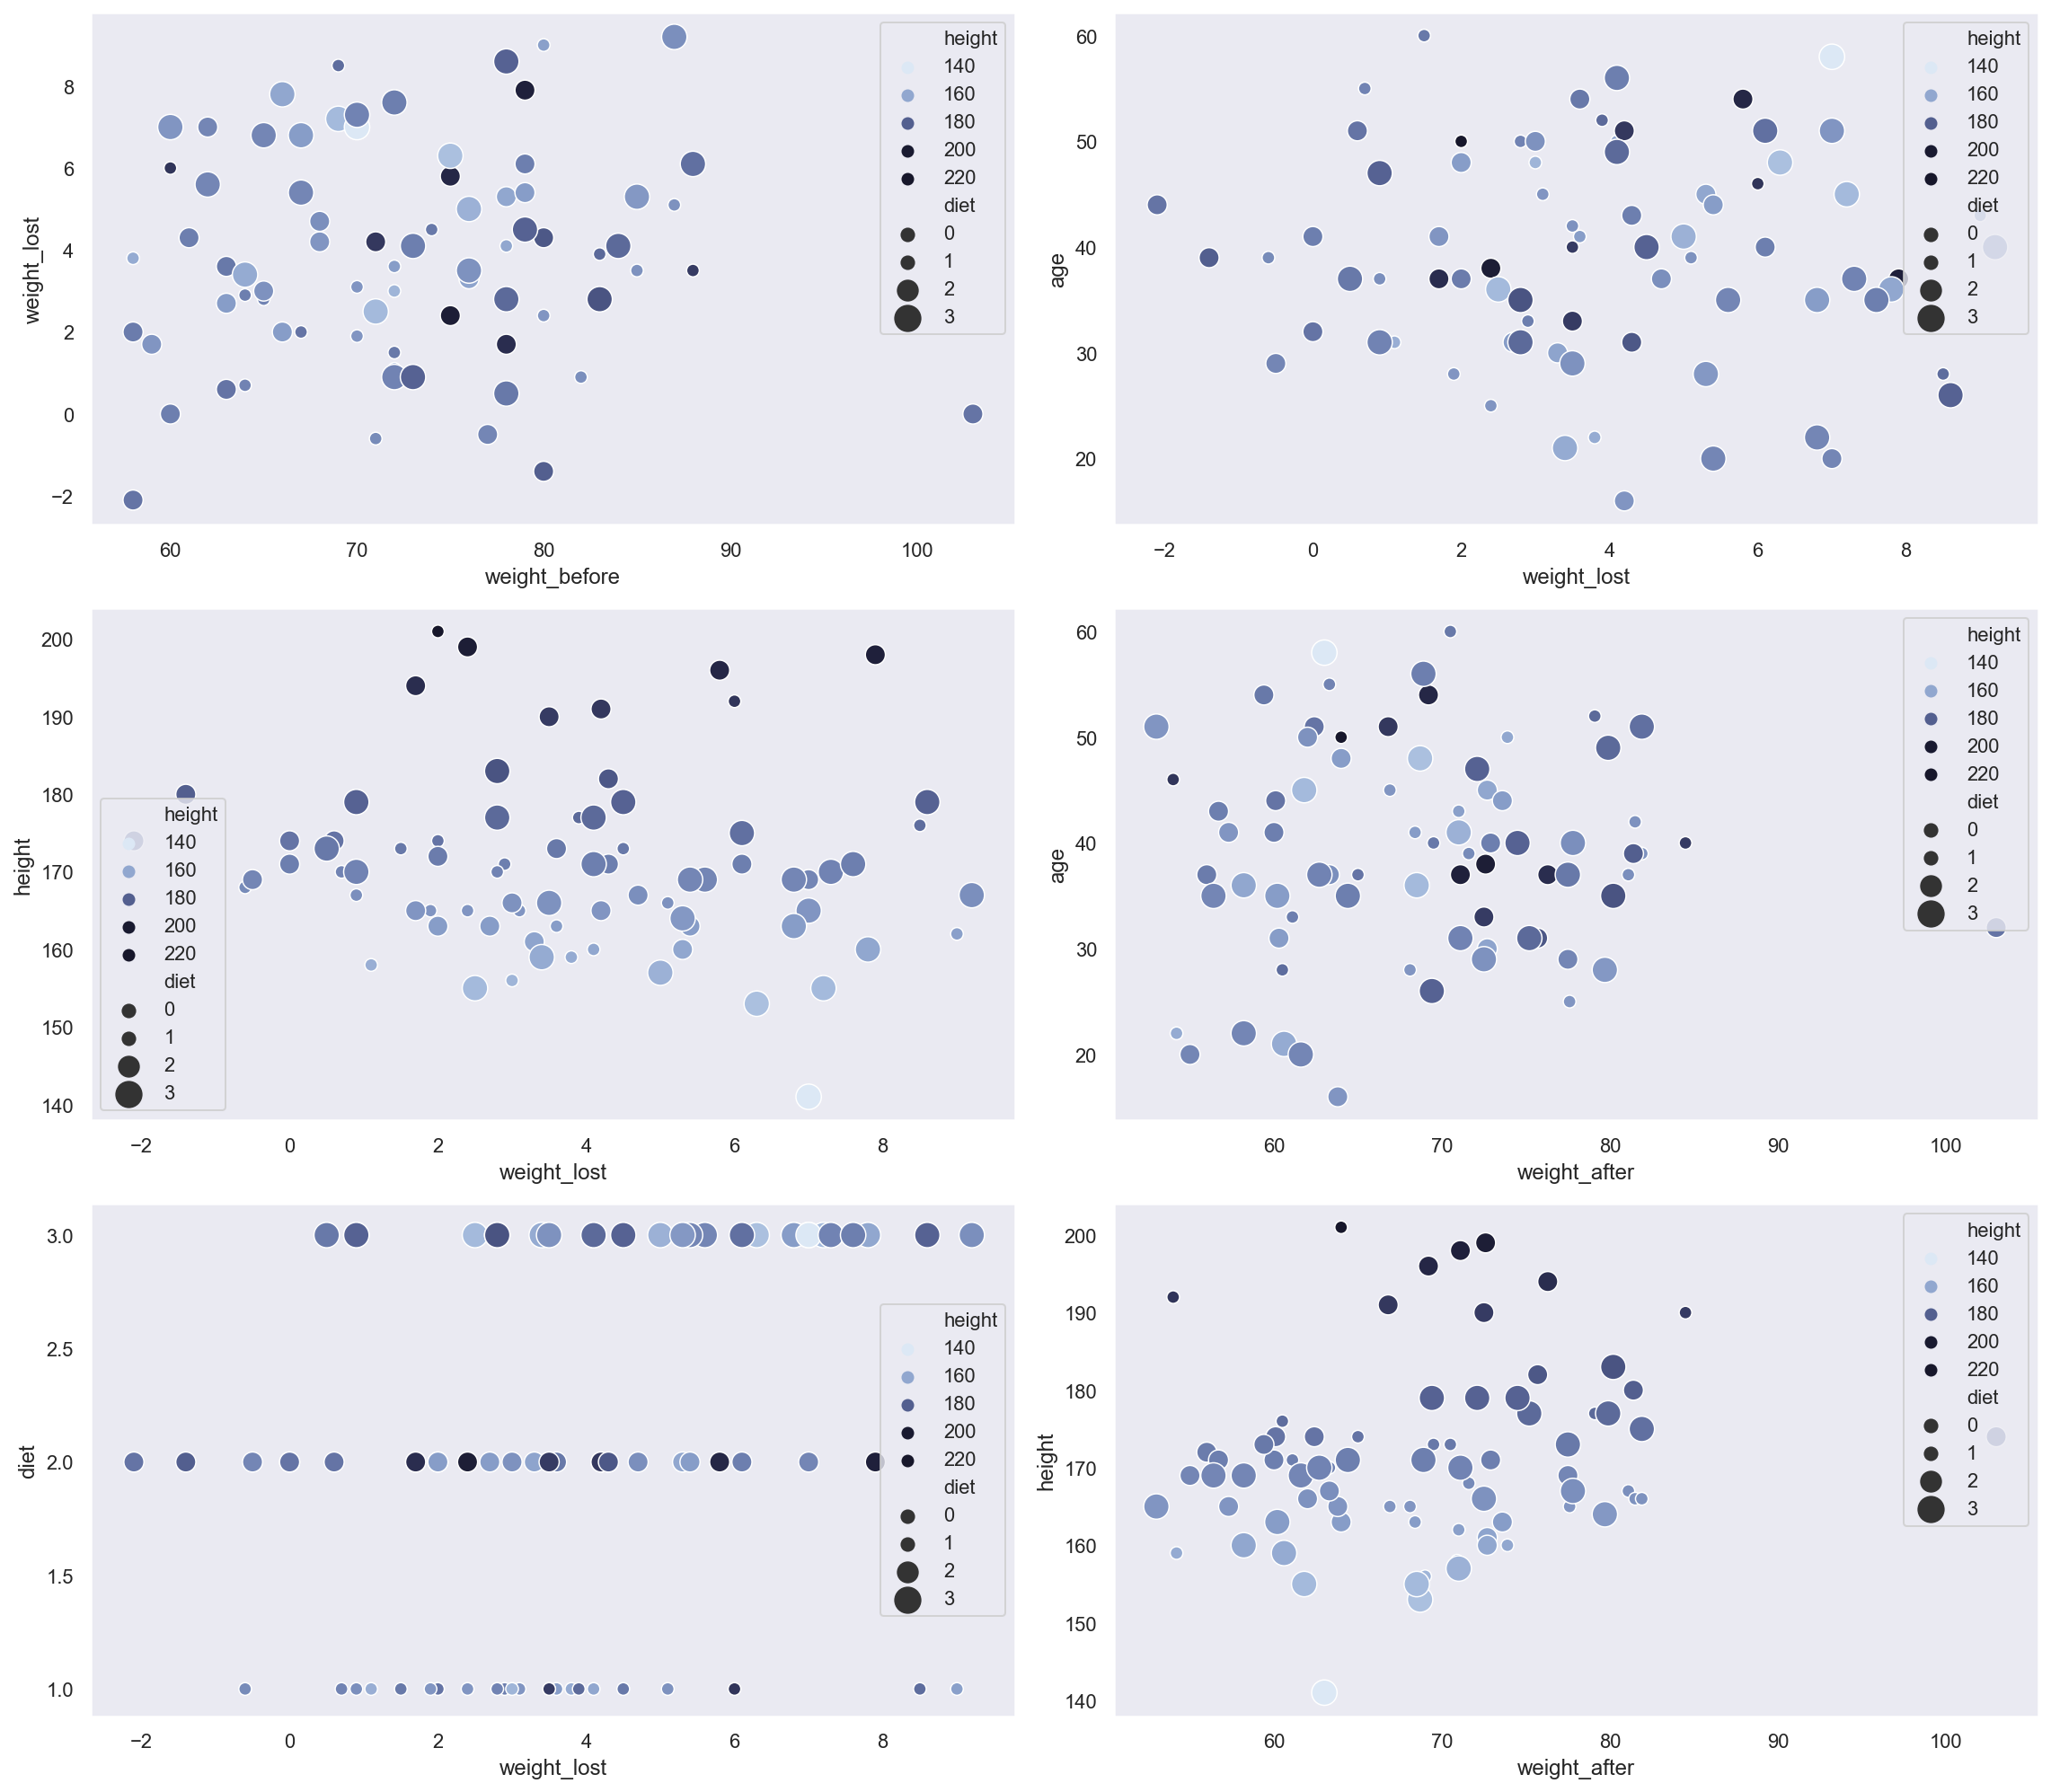

In [32]:
fig, ax = plt.subplots(3,2,figsize=(16,14))
#cmap = sns.cubehelix_palette(rot=-.1, as_cmap=True)
cmap = sns.cubehelix_palette(rot=-.1, dark=.1, light=.9, as_cmap=True)
sns.scatterplot(x="weight_before", y="weight_lost",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[0][0])
sns.scatterplot(x="weight_lost", y="age",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[0][1])
sns.scatterplot(x="weight_lost", y="height",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[1][0])
sns.scatterplot(x="weight_after", y="age",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[1][1])
sns.scatterplot(x="weight_after", y="height",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[2][1])
sns.scatterplot(x="weight_lost", y="diet",
                     hue="height", size="diet",
                     palette=cmap, sizes=(50, 200),
                     data=df,ax=ax[2][0])
plt.tight_layout();

After getting acquainted with the data we can proceed to our analysis.

<a id='one_way'></a>
# One-way analysis of variance

In our dataset there are 3 different types of diet. 78 people have been selected and divided into independent groups. After six weeks of special diet each participant's weight was measured. Our task is to find whether there is a difference between weights of participants in our observed groups.
$H_0: \mu_1 = \mu_2 = \mu_3$ -- there is no difference between types of diet.\
$H_1: \mu_1 \neq \mu_2 \neq \mu_3$ -- at lest two groups have differences\
Independent variable: `diet`\
Dependent variable: `weight`

<a id='assumptions'></a>
### ANOVA assumptions:
 - Dependent variable is normally distributed in each group (Shapiro-Wilks Test)
 - Homogeneity of variances (variances are equal between  groups) (Levene or Bartlett Test)
 - Observations are sampled independently from each other

#### Check if our sample was obtained from  general population, where observed attribute distributed normally.
1. Q-Q plot
2. Shapiro-Wilks Test

When testing our data for compliance to normal distribution, our $H_0$ is that data was obtain from normal distribution,in that case, if `p_value` > 0.05, we fail to reject the null hypothesis.

In [33]:
group_1 = df[df.diet == 1]
group_2 = df[df.diet == 2]
group_3 = df[df.diet == 3]

<a id='q-q'></a>
### Q-Q plot

In [34]:
def test_for_nd(group, attribute) -> None:
    """
    Creates Q-Q plot
    and prints results of
    two tests for compliance
    to normal disribution.
    
    Parameters:
    group : pandas.DataFrame
    attribute : str
        column name to test
    """
    samp_mean = group[attribute].mean()
    samp_std = group[attribute].std()
    n_points = group.shape[0]
    qs = (np.arange(n_points) - .5) / n_points
    expected_vals = norm.ppf(qs)
    data_scores = (group[attribute].sort_values() - samp_mean) / samp_std
    x_edges = [round(np.nanmin(expected_vals),1), round(np.nanmax(expected_vals),1)]
    y_edges = [round(min(data_scores),1), round(max(data_scores),1)]
    plt.figure(figsize=(8,6))
    plt.scatter(expected_vals, data_scores)
    #plt.plot([-2.03,1.53],[-1.77,1.8],'--', color = 'black')
    plt.plot(x_edges,y_edges,'--', color='black')
    plt.axis('equal')
    plt.xlabel('Expected Standard Scores')
    plt.ylabel('Observed Standars Scores')
    plt.title(f'Quantile-Quantile plot for {attribute}')
    w, pvalue = stats.shapiro(group[attribute])
    print(' '*12 + f'Shapiro-Wilks Test results'+ ' '*12)
    print(f'Test statistic is {w} and p_value is {pvalue}')
    print(' '*12 +'*'*24)

            Shapiro-Wilks Test results            
Test statistic is 0.9627647995948792 and p_value is 0.4964383840560913
            ************************
            Shapiro-Wilks Test results            
Test statistic is 0.8830754160881042 and p_value is 0.005601357202976942
            ************************
            Shapiro-Wilks Test results            
Test statistic is 0.9754430651664734 and p_value is 0.7483453750610352
            ************************


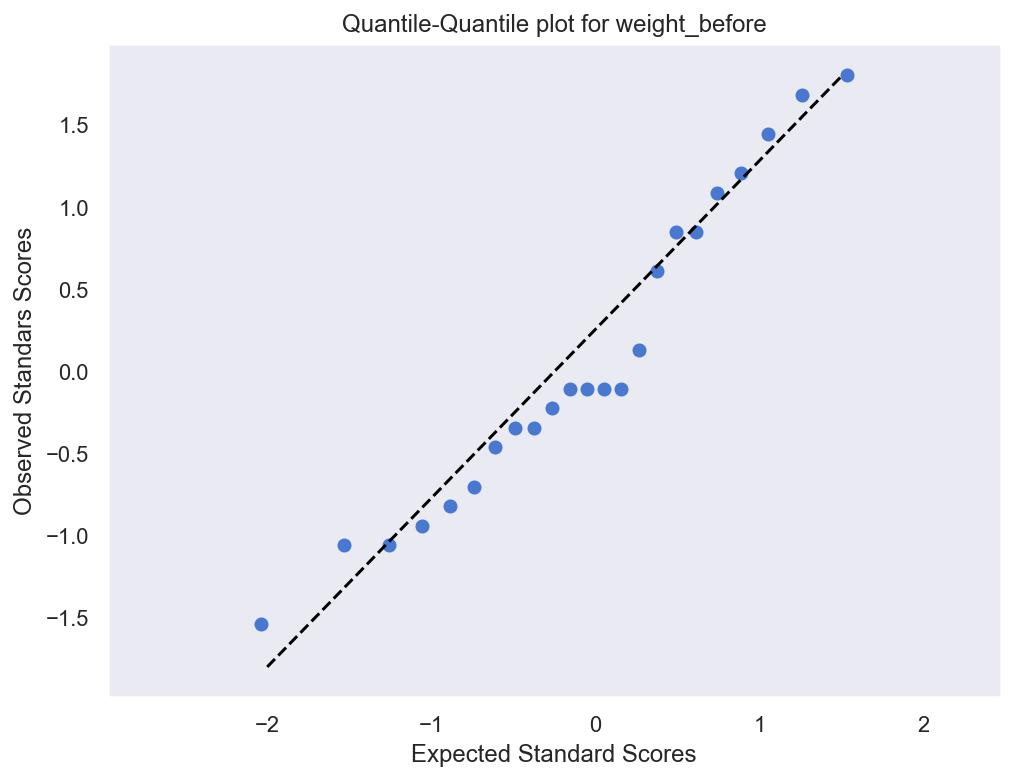

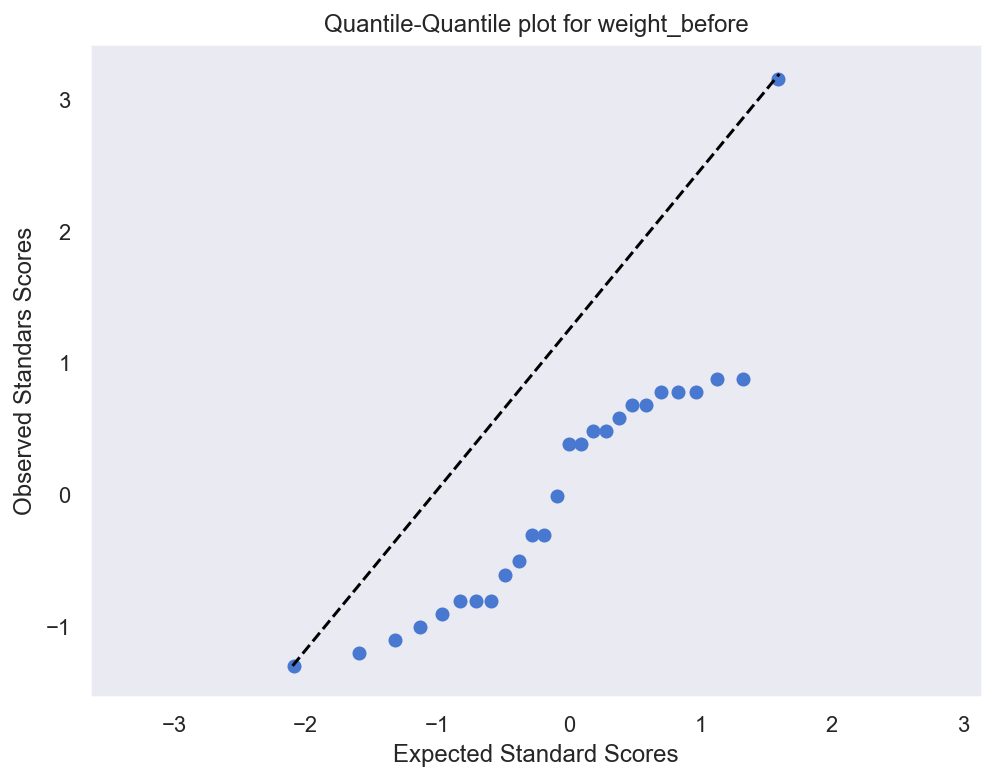

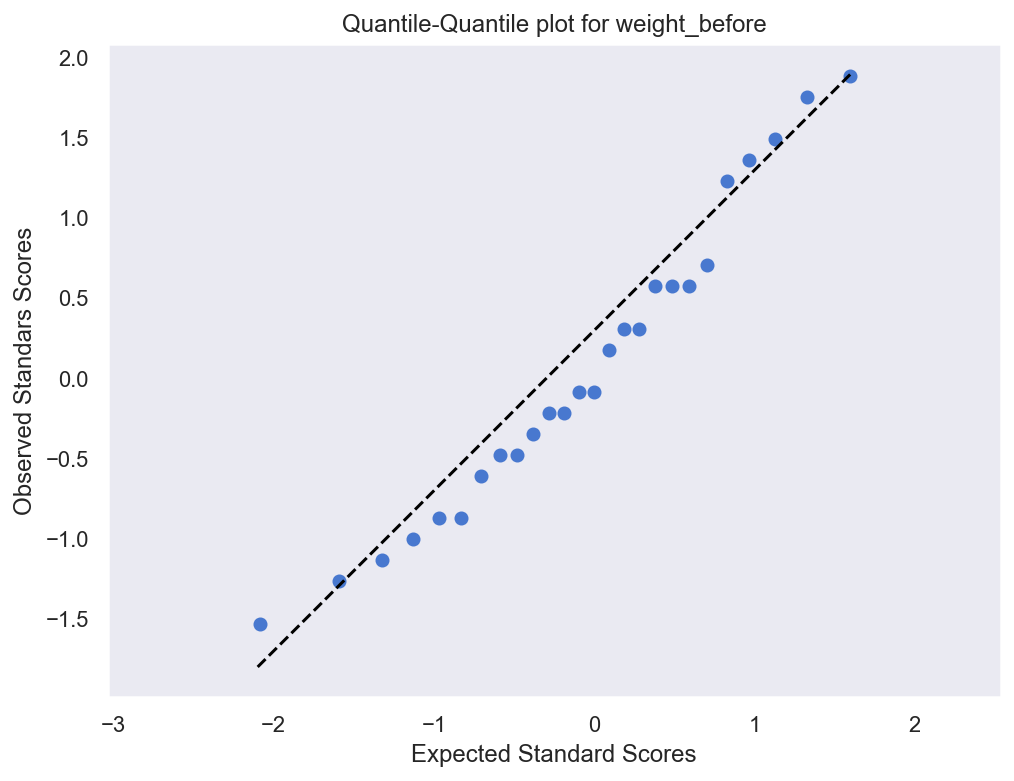

In [35]:
for group in (group_1, group_2, group_3):
    test_for_nd(group, 'weight_before')

Not as clean as expected, but we can live with that.\


<a id='homo'></a>
### Homogenity of variances
Now let's test homogeneity of variances. We will use  Levene's test for equality of variances, as our attribute has quite significant deviation from normal distribution. The Levene test tests the null hypothesis that all input samples are from populations with equal variances [source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)\
$H_0$ : All of the k sample populations have equal variances.\
$H_1$: At least one of the three sample population variances are not equal.

In [36]:
# 'Median' recommended for skewed  distributions.
var='weight_before'
stats.levene(group_1[var].values, group_2[var].values,group_3[var].values, center='median')

LeveneResult(statistic=1.231370000154861, pvalue=0.29772501456183936)

p_value > 0.05, therefore we fail to reject null hypothesis. Another assumption has been successfully tested, now, we can proceed to calculations of variance.

<a id='calc'></a>
## Calculations

In [37]:
# check shapes
print(group_1.shape)
print(group_2.shape)
print(group_3.shape)

(24, 7)
(27, 7)
(27, 7)


What we need is our groups to be the same shape. So, randomly selecting and deleting samples is the best idea here.

In [38]:
sample_2 = group_2.sample(3).index
sample_3 = group_3.sample(3).index
group_2.drop(index=sample_2, inplace=True)
group_3.drop(index=sample_3, inplace=True)

In [39]:
# check again
print(group_1.shape)
print(group_2.shape)
print(group_3.shape)

(24, 7)
(24, 7)
(24, 7)


Looks good!

In [40]:
# find mean of all groups
var = 'weight_lost'
all_vars = np.concatenate([group_1[var].values,group_2[var].values, group_3[var].values])
x_mean = np.mean(all_vars)

In [41]:
x_mean

3.8708333333333322

In [42]:
# Total sum of squares
SST = np.sum((group_1[var].values-x_mean)**2) + np.sum((group_2[var].values-x_mean)**2) +\
                                                np.sum((group_3[var].values-x_mean)**2)

In [43]:
# Degrees of freedomg
deg_f = (24*3)-1

In [6]:
def calculate_SSW(groups) -> (int, float):
    """
    Calculates sum of squares withih group.
    --------------------------------------
    Parameters:
    groups : tuple
    """
    gr1, gr2, gr3 = groups
    mean1 = gr1.mean() 
    mean2 = gr2.mean()
    mean3 = gr3.mean()
    sum1 = np.sum([(x-mean1)**2 for x in gr1])
    sum2 = np.sum([(x-mean2)**2 for x in gr2])
    sum3 = np.sum([(x-mean3)**2 for x in gr3])
    degrees = (24*3)-3
    SSW = sum1 + sum2 + sum3
    return degrees, SSW
    
    

In [45]:
#Sum of squares bentween groups
def calculate_SSB(groups) -> (int, float):
    """
    Calculates sum of squares withih group.
    --------------------------------------
    Parameters:
    groups : tuple
    """
    n_elem = 24
    gr1, gr2, gr3 = groups
    mean1 = gr1.mean() 
    mean2 = gr2.mean()
    mean3 = gr3.mean()
    SSB = n_elem*(mean1-x_mean)**2 + n_elem*(mean2-x_mean)**2 + n_elem*(mean3-x_mean)**2
    degrees = 2
    return degrees, SSB

In [46]:
groups = (group_1[var].values, group_2[var].values, group_3[var].values)

In [47]:
degrees_SSW,SSW = calculate_SSW(*groups)

In [48]:
degrees_SSB, SSB = calculate_SSB(*groups)

In [49]:
# should be True
(SSW+SSB) == SST

True

In [50]:
F = (SSB/degrees_SSB) / (SSW/degrees_SSW)

In [51]:
F

4.81735738694665

We got F-statistic value, let's try to visualize and understand what does this mean

<a id='f-dist'></a>
### Drawing F-distribution

In [86]:
# from scipy docs
dfn, dfd = 2, (24*3)-3
r = f.rvs(dfn, dfd, size=24*3)

In [53]:
x = np.linspace(f.ppf(0.01, dfn, dfd),
               f.ppf(0.99, dfn, dfd), 24*3)

In [54]:
# random values
rv = f(dfn, dfd)

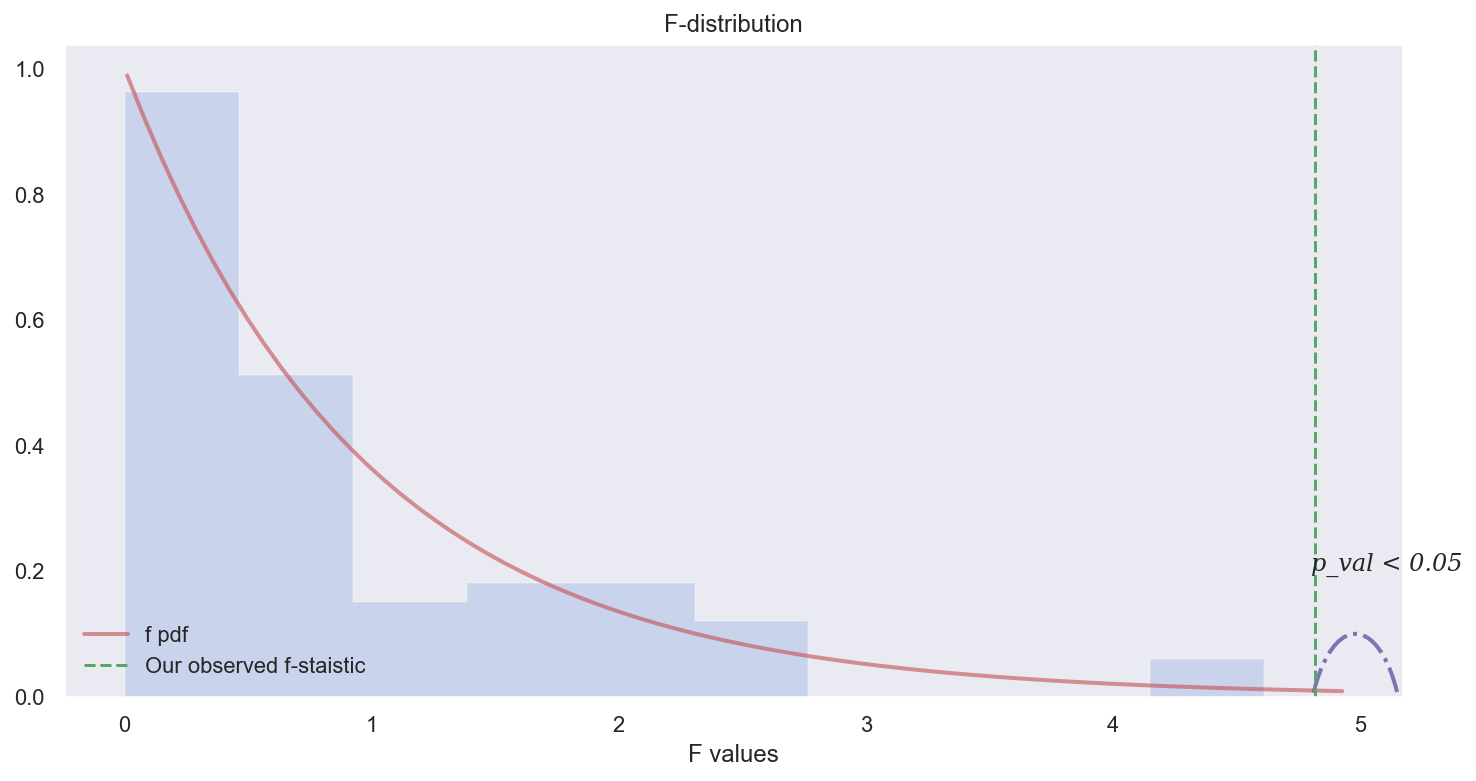

In [79]:
fig, ax = plt.subplots(figsize=(12,6))
circle1 = plt.Circle((4.98, -0.1), 0.2, color='m',lw=2, fill=False, linestyle='-.')
ax = plt.gca()
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, f.pdf(x, dfn, dfd),
             'r-', lw=2, alpha=0.6, label='f pdf')
ax.axvline(F, linestyle='--', c='g', label='Our observed f-staistic')
ax.add_artist(circle1)
ax.legend(loc='best', frameon=False)
ax.set(title='F-distribution', xlabel='F values')
t= ("p_val < 0.05")
plt.text(4.80,0.2, t, family='serif', style='italic', wrap=True)
plt.show()

So, chances of observing this F-statistic or higher are really small, therefore we reject null hypothesis and that means there are significant differences in our groups and at least two groups have differences. But we don't know exactly which. \
We could also get  results just in two clicks using scipy package.

In [58]:
# the same as our observed F
var = 'weight_lost'
stats.f_oneway(group_1[var].values, group_2[var].values, group_3[var].values)

F_onewayResult(statistic=4.817357386946652, pvalue=0.011005245472069533)

<a id='tukey'></a>
### Tukey HSD test

To know the pairs of significantly different diets, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

In [67]:
m_comp = pairwise_tukeyhsd(endog=df['weight_lost'], groups=df['diet'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.2741  -1.8806 1.3325 False 
  1      3     1.8481   0.2416 3.4547  True 
  2      3     2.1222   0.5636 3.6808  True 
--------------------------------------------


Above results from Tukey HSD suggests that except 1-3 and 2-3 groups, all other pairwise comparisons for treatments rejects null hypothesis and indicates statistical significant differences.

Let's visualize our statistic

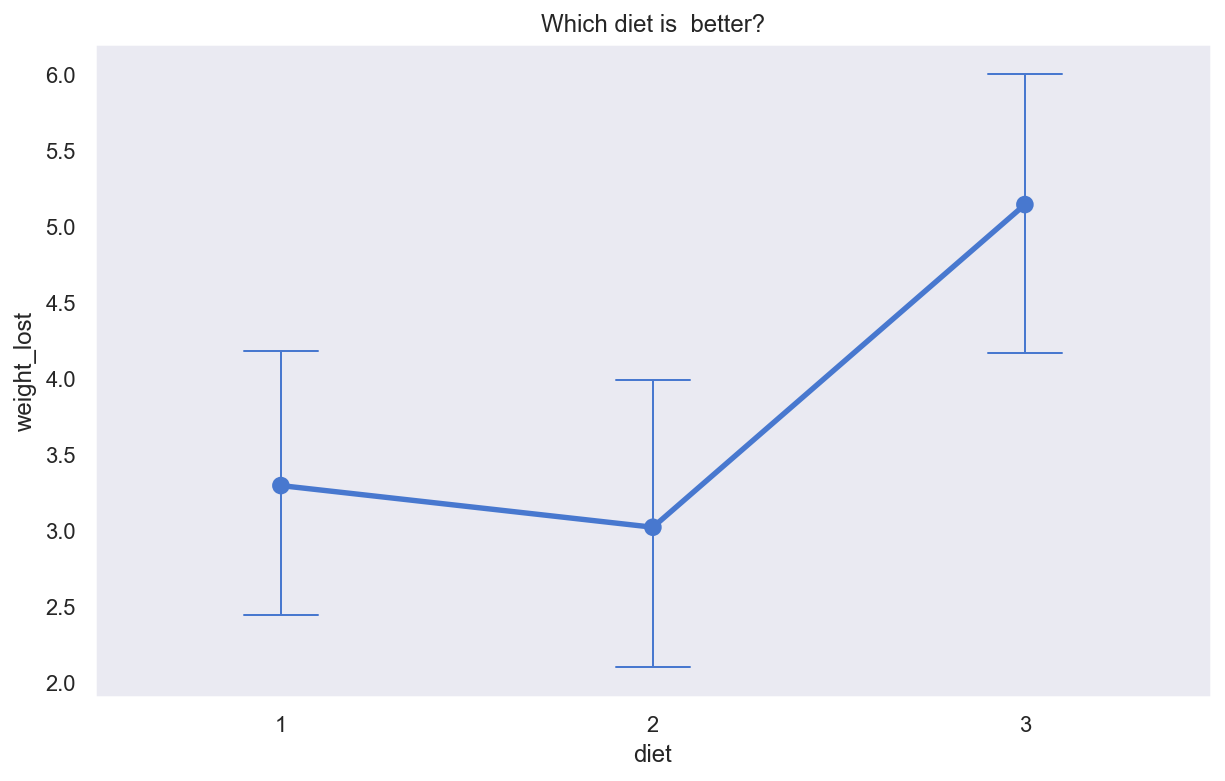

In [82]:
plt.figure(figsize=(10,6))
sns.pointplot(data=df, x='diet', y='weight_lost', dodge=True, capsize=.2, errwidth=1)
plt.title('Which diet is  better?');

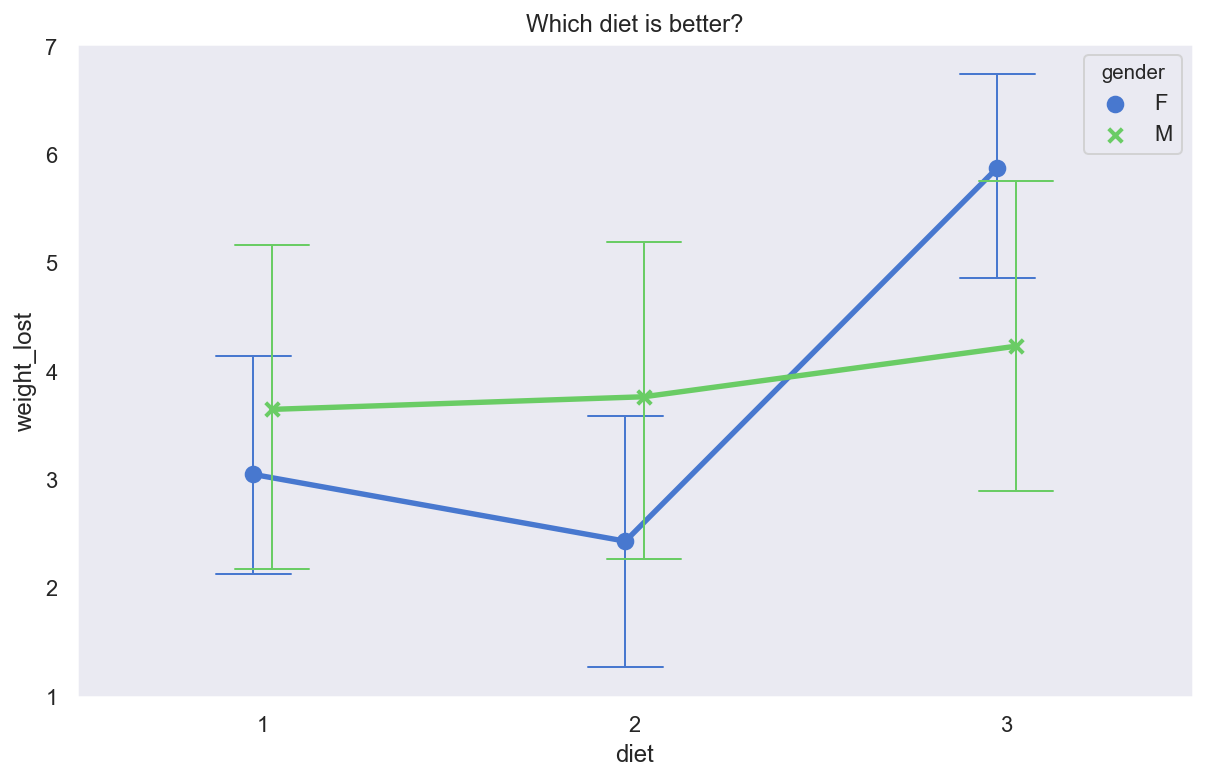

In [85]:
plt.figure(figsize=(10,6))
sns.pointplot(data=df, x='diet', y='weight_lost', hue='gender', dodge=True, markers=['o', 'x'],
capsize=.2, errwidth=1)
plt.title('Which diet is better?');

As from what we can see, for females third diet is much better than others. For males there is no significant differences. But in that case we should perform two-way analysis of varience.

<a id='conc'></a>
### Conclusion

To sum up, we performed one-way analysis of varience, tested different assumptions and drew multiple plots. Despite the fact that nowadays you can do it by several cliks, it is always a good practise to calculate it by hands and gett better sense of what happens under the hood.